## Library Imports

In [15]:
%matplotlib inline
import numpy as np 
import pandas as pd 

# Traditional ML library
import sklearn 
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
#import matplotlib.pylab as plt 

## Function Definition

In [35]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        uses mglearn.tools.heatmap() for plotting.
        
    '''
    results = pd.DataFrame(grid_search.cv_results_)
    params = sorted(grid_search.param_grid.keys())
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="YlGnBu", fmt="%0.3f")

## Initial Data Analysis

In [2]:
# Features/columns to be removed for several reasons: ethical irrelevant feature, etc
to_remove = ["job_name", "reason","channel","n_issues","ok_since","zip","gender"] 

# Read train and test data and drop columns
df_train = pd.read_csv("puzzle_train_dataset.csv").set_index("ids").drop(to_remove, axis=1)
df_test = pd.read_csv("puzzle_test_dataset.csv").set_index("ids").drop(to_remove, axis=1)

print("Nb. of train samples: %d" %df_train.shape[0])
print("Number of test samples:  %d" %df_test.shape[0])
print("Nb. features: %d" %(df_train.shape[1]-1))

# Remove samples with missing labels
df_train = df_train[pd.notnull(df_train['default'])]
df_train["default"] = df_train["default"].astype("int")

print("Nb. of train samples after removing samples with no label: %d" %df_train.shape[0])
print("Classes ratio (False/True): %f" %((df_train["default"] == 0).sum()/(df_train["default"] == 1).sum()))


# Dataset information
feats_info = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.T.apply(lambda x: x.nunique(), axis=1)], axis=1)
feats_info.columns = ["Missing","Type","Unique"]
print("\n Dataset Information (missing features, data type, unique values)")
print(feats_info)

Nb. of train samples: 64592
Number of test samples:  35000
Nb. features: 18
Nb. of train samples after removing samples with no label: 59966
Classes ratio (False/True): 5.305573

 Dataset Information (missing features, data type, unique values)
                    Missing     Type  Unique
default                   0    int32       2
score_1                   0   object       7
score_2                   0   object      35
score_3                   0  float64      87
score_4                   0  float64   59966
score_5                   0  float64   59966
score_6                   0  float64   59966
risk_rate                 0  float64      81
amount_borrowed           0  float64   50484
borrowed_in_months        0  float64       2
credit_limit          18779  float64   26238
income                    0  float64   54273
sign                  18938   object      12
facebook_profile       5971   object       2
state                     0   object      50
real_state                0   objec

## Categorical Data Encoding

In [3]:
def get_encoder(df, col):
    dft = df[col].astype(str).to_frame().copy()
    dft["count"] = 1
    return dft.groupby(col).count().to_dict()["count"]
    
def encode_all(df_train, df_test, cols):
    for col in cols:
        enc = get_encoder(df_train, col)
        df_train[col] = df_train[col].astype(str).apply(lambda x: enc.get(x, -1))
        df_test[col] = df_test[col].astype(str).apply(lambda x: enc.get(x, -1))
    return df_train, df_test


# Create additional binary features flag for missing values for all features that have missing values
for col in df_test.columns:
    df_train["is_" + col + "_missing"] = df_train[col].isnull() * 1
    df_test["is_" + col + "_missing"] = df_test[col].isnull() * 1

# Represent categorical feature as a series o binary values and drop first column to avoid redundancy
df_train = pd.get_dummies(df_train, columns=['score_1','score_2','real_state'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['score_1','score_2','real_state'], drop_first=True)

encode_cols = df_train.dtypes
encode_cols = encode_cols[encode_cols == object].index.tolist()


# Encode categorical variables and replace NaN by -1
df_train, df_test = encode_all(df_train, df_test, encode_cols)
df_train, df_test = df_train.fillna(-1), df_test.fillna(-1)


## Feature and Label Extraction

In [4]:
# Split features and labels
X_train, y_train = df_train.drop(["default"], axis=1), df_train["default"]
X_test = df_test
y_train.shape

(59966,)

## Label Distribution

Text(0.5, 1.0, 'Histogram of Default Labels\n')

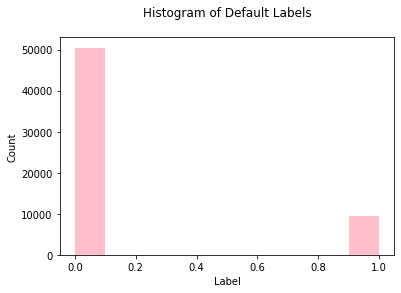

In [5]:
plt.hist(y_train, color='pink')
plt.ylabel("Count")
plt.xlabel("Label")
plt.title("Histogram of Default Labels\n")

## Train Set

In [6]:
# Print first rows of the training set
X_train.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
810e3277-619e-3154-7ba0-ebddfc5f7ea9,710.0,104.174961,0.661509,123.015325,0.43,20024.31,60.0,62386.0,59869.05,5571,...,1,0,0,0,0,0,0,0,1,0
b4118fd5-77d5-4d80-3617-bacd7aaf1a88,330.0,97.880798,0.531115,110.913484,0.23,10046.51,36.0,-1.0,46016.31,1402,...,0,0,0,0,0,0,0,0,1,0
a75638f1-4662-4f4f-044a-d649b676d85d,360.0,97.908925,0.611086,104.620791,0.30,21228.25,60.0,-1.0,48025.47,5582,...,0,0,0,0,0,1,1,0,0,0
285ce334-3602-42b3-51cb-eebfcba48a09,120.0,100.434557,0.139784,120.134718,0.15,23032.33,36.0,-1.0,46011.12,18938,...,0,1,0,0,0,0,1,0,0,0
e643bf65-9288-92f2-df13-eed631fe237c,330.0,103.774638,0.002856,104.320462,0.08,24026.29,36.0,32366.0,90026.17,5582,...,0,0,0,0,0,0,1,0,0,0


## Test Set

In [7]:
# Print first rows of the test set
X_test.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
e4366223-7aa2-0904-7a47-66479ae46b2a,230.0,101.906686,0.677760,77.245320,0.22,21016.38,36.0,43666.0,156021.02,18938,...,0,0,0,0,0,0,1,0,0,0
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,400.0,96.276632,0.278711,94.980774,0.13,1211.74,36.0,-1.0,8410.56,1402,...,0,0,0,0,0,0,1,0,0,0
a90d3929-86ec-2414-89ba-543776b0e82b,420.0,98.901695,0.894661,108.136546,0.25,6990.63,36.0,-1.0,45116.60,3499,...,0,0,0,0,0,0,1,0,0,0
c5b96a7f-389a-28d0-242d-95db05e69da0,490.0,95.975994,0.972729,126.120768,0.46,15025.67,60.0,71273.0,60029.26,2839,...,0,0,0,0,0,0,0,0,1,0
1b461faa-926d-565d-b15d-0b452968ac81,320.0,101.303601,0.234202,107.162760,0.29,7027.81,36.0,-1.0,27618.96,3499,...,0,0,0,0,0,0,0,0,1,0


## GridSearch Estimator

In [8]:
from pprint import pprint
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 400, stop = 2000, num =5)] # Number of trees in random forest

max_depth = [int(x) for x in np.linspace(10, 50, num = 5)] # depth of the tree

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,}

pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50],
 'n_estimators': [400, 800, 1200, 1600, 2000]}


## Balanced RandomForrest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf = BalancedRandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1, return_train_score=True)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [400, 800, 1200, 1600, 2000]},
             return_train_score=True, verbose=2)

## Grid Search Result

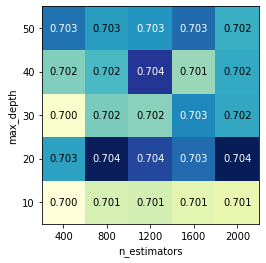

In [36]:
plot_grid_search_results(rf_grid)

## Optimal Parameters (max_depth = 20, n_estimator = 2000)

In [11]:
print(rf_grid.best_params_)

{'max_depth': 20, 'n_estimators': 2000}


## Area Under the Curve (AUC)

In [13]:
rfc = BalancedRandomForestClassifier(max_depth = 20, n_estimators = 2000)
skf = StratifiedKFold(5, shuffle=True, random_state=100)
cm = np.zeros((2,2))
aucs = []

for (fold, (i_train, i_test)) in enumerate(skf.split(X_train, y_train)):
    rfc.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = rfc.predict_proba(X_train.iloc[i_test])
    pred = rfc.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs.append(auc)
    cm += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
    
print("AUC: %2.3f +- %2.4f" % (np.mean(aucs), np.std(aucs)))

(11994, 2)
AUC score on fold 0: 0.759
(11993, 2)
AUC score on fold 1: 0.761
(11993, 2)
AUC score on fold 2: 0.755
(11993, 2)
AUC score on fold 3: 0.764
(11993, 2)
AUC score on fold 4: 0.762
AUC: 0.760 +- 0.0030


## Confusion Matrix

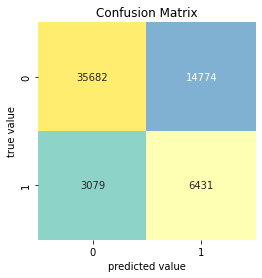

In [21]:
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap=plt.cm.Set3)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

## Accuracy, Precision, Recall, F1-score

In [22]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP+TN)/(TP+TN+FN+FP)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy = %2.3f" %(cm.diagonal().sum()/cm.sum()))
print("Precision = %2.3f" %precision)
print("Recall = %2.3f" %recall)
print("F1-score = %2.3f" %f1)

Accuracy = 0.702
Precision = 0.303
Recall = 0.676
F1-score = 0.419


## Feature Importance

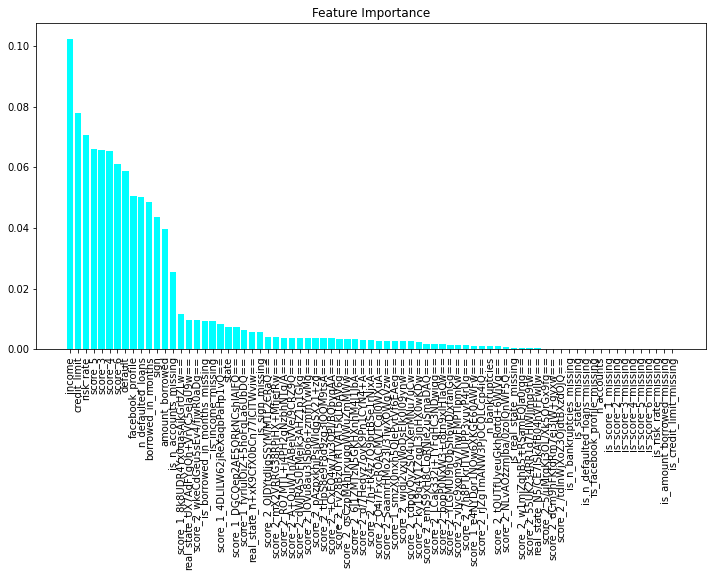

In [38]:
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances[indices], align="center", color='cyan')
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

## Label Prediction (default/non-default)

In [39]:
rfc_label_prediction = pd.DataFrame(rfc.predict_proba(X_test)[:, 1], columns=["predictions"], index=X_test.index)
rfc_label_prediction.to_csv("balanced_rfc_label_prediction.csv")
print(rfc_label_prediction)

                                      predictions
ids                                              
e4366223-7aa2-0904-7a47-66479ae46b2a     0.385331
c6416108-c6d7-e6be-c4b5-923dd36c8ec4     0.480183
a90d3929-86ec-2414-89ba-543776b0e82b     0.455322
c5b96a7f-389a-28d0-242d-95db05e69da0     0.769043
1b461faa-926d-565d-b15d-0b452968ac81     0.672685
...                                           ...
cfe269ae-b893-c084-f9f5-3b91f9725b71     0.411809
2feff27a-3dcf-1e19-7583-a8eab192fd23     0.325219
601509fd-20d9-d3b8-b143-defcf5457d2c     0.412998
b0168e1c-ddbd-1b2c-acfb-f09638e1ee34     0.276656
508276ff-56cb-243c-da1d-4929c1411344     0.422362

[35000 rows x 1 columns]


# Balanced RandomForestClassifier Recall = 68% 🦩🐸🐬